In [1]:
from src.setup import *

# Anomaly Detection

_The map is not the territory and data is not the world observed. 
Data is messy, inconsistent, and unreliable. The world is messier, 
less consistent, and less reliable._

–c.f. Alfred Korzybski.

When we think about anomaly detection, there are two distinct, and mostly independent, concepts that go by the name.  The topic of this lesson is perhaps the less exciting of the two.  

Security and cryptography researchers, importantly, look for anomalies that can represent fraud, forgery, and system intrusion attempts.  By the intention of perpetrators, these outliers in the normal patterns of data are subtle and hard to detect, and a conflict exists between those wishing to falsify data and those wishing to detect that falsification.

The concept of interest to us in this lesson is more quotidian.  We wish to detect those cases where data goes bad in the ordinary course of its collection, collation, transmission, and transcription.  Perhaps an instrument gives a bad reading some or all of the time.  Perhaps some values are systematically altered in the course of reencoding to a different data format.  Perhaps the wrong units of measure were used for a subset of the data.  

By accident, these broader checks may occasionally identify changes that reflect actual malice, but more often they will simply detect errors.  They can *perhaps* detect bias, but less often since bias still usually consists of *plausible* values.

Anomalies are related to data quality. However, anomalies are more about individual data values that can be identified as probably wrong, whereas data quality more broadly looks at *patterns* of a data set that can present or identify problems.  

When anomalies *are* detected it sometimes makes sense to impute more likely values rather than discard those observations altogether.  This lessons focuses on identifying anomalies and marking them as "missing." The later lesson on value imputation will pick up with filling in plausible replacement values.

## Missing Data

* Sentinels versus explicit absence
* Semantics of NULL, NaN, and N/A
* Nullable columns in SQL
* Absence in hierarchies
* Pitfalls of sentinels

Some data formats explicitly support missing data while other formats use a special values, known as sentinels to indicate missingness.  Non-tabular formats may indicate missing data simply by not including any value in a position where it might otherwise occur.  However, sentinel values are sometimes ambiguous, unfortunately.

In particular, within many data formats, and within some data frame libraries, missing numeric values are represented by the special IEEE-754 floating-point value NaN (Not-a-Number).   As a small digression, let us look at coaxing a NaN to arise in an "ordinary" computation.

In [2]:
for n in range(7, 10):
    exp = 2**n
    a = (22/7) ** exp 
    b = π ** exp
    # Compute answer in two "equivalent" ways
    res1 = (a * a) / (b * b)
    res2 = (a / b) * (a / b)
    print(f"n={n}:\n  "
          f"method1: {res1:.3f}\n  "
          f"method2: {res2:.3f}")

n=7:
  method1: 1.109
  method2: 1.109
n=8:
  method1: 1.229
  method2: 1.229
n=9:
  method1: nan
  method2: 1.510


The rational number 22/7 is famously close to the irrational number pi.  The simple code above takes each number to a large exponent, then figures out the ratio of the two results.  The answers we get are of quite ordinary size, each a bit larger than one, but less than two.

In pure artithmetic, multiplying `a` times `a`, then dividing by `b` times `b`, is identical to doing the two separate divisions then multiplying them together.  However, actual floating point numbers experience overflows, which happens under one method but not the other.

The NaN in our toy code arises as the result of a computation that is not _obviously unreasonable_.  While such an unrepresentable value is indeed *unavailable*, it is semantically different from data that was simply never collected in the first place.

### Personal name data

```
| FirstName     | MiddleName    | LastName
|---------------|---------------|---------------
| Polly         | Jean          | Harvey
| Dick          |               | Dale
| Joey          | Santiago      | Alberto
| Chris         | ""            | Knox
| Gibby         | N/A           | Haynes
```

Parallel to the pitfall of missing floats being represented as NaNs, missing strings are almost always represented as *strings*.  Generally, one or more reserved values such as 'N/A' or the empty string are used when a string value is missing.  However, those sentinels do not clearly distinguish between "not applicable" and "not available" which are subtly different.  

For example, we might have collected names of people, including "middle name."  Having a sentinel value for middle name would not distinguish between survey subjects who have no middle name and those who merely had not provided it.

Perhaps we wish to find the correlation between certain middle names and demographic characteristics.  In the United States, for example, the middle name "Santiago" would be strongly associated with Hispanic family origin; a survey subject who _provided_ no middle name might nonetheless have that middle name.  In principle, a string field could contain different sentinels for "No middle name" versus "No response" but data sets are *very rarely* careful in those distinctions.

## SQL

In SQL databases, an explicit NULL is available for all column type, but only if a column has been declared as "nullable."  This allows a distinction in principle between an explicit NaN for a numeric field and a NULL for missing values.  

Unfortunately, many or most real-world database tables fail to utilize available distinctions.  In practice, you are likely to see many combinations of empty strings, NaNs, actual NULLs, or other sentinels, even within SQL databases. This is not because any widely used RDBMS fails to support these different values and types, it is rather that in the history of various clients putting data into them, using various codebases, non-optimal choices were made.

```
sqlite> .header on
sqlite> .mode column
sqlite> .nullvalue NULL
sqlite> SELECT ROW_NUMBER() OVER (ORDER BY '') "#", amount, description FROM sentinels;
#  amount  description
-  ------  -----------
1  NaN     Not number
2  1.23    A number
3  NULL    A null
4  3.45    Santiago
5  6.78
6  9.01    NULL
```

A small table is shown from the `sqlite3` shell, where the column `amount` is REAL and `description` is STRING.  This illustrates varying sentinels we commonly see.  We might treat NULL as "not available" and a NaN or empty string as "not applicable."

* Row 1 contains a NaN and a string description;
* Row 2 contains a float value and a string;
* Row 3 contains an SQL NULL and a string;
* Row 4 contains a float value and a string;
* Row 5 contains a float value and an empty string;
* Row 6 contains a float value and a NULL.

Different libraries vary in their nuance in distinguishing sentinels.  

The R Tidyverse—which we do not utilize in this course—is pretty good in distinguishing both NaN and a special `NA` value; but it also provides an even more special pseudo-value `NULL` which explicitly means "missing."

The Pandas library has technically introduced a special `pd.NA` value that would, in concept, allow more nuanced distinctions, but in practice almost every Pandas method uses NaN whenever it is unsure about the status of a value.  This has the additional negative consequence of frequently casting non-float values to floats because NaN is strictly only a floating-point value.

Polars is cleaner than Pandas in using a true `null` for all data types, and treating NaN as simply a special floating-point value (much like infinity or -infinity are).

## Hierarchical Formats

In formats like JSON that nest data flexibly, there is an obvious way of representing missing data: by not representing it at all.  If you perform hierarchical processing, you will need to check for the presence or absence of a given dictionary key at a given level.

The JSON specification itself does not address NaN values, which means that some systems producing data may choose to use the Javascript `null` value in its place, producing the ambiguity we have discussed above.  However, many specific libraries extend the definition to recognize NaN (and sometimes `inf`, which is also a floating-point number) as a value.

In [3]:
json.loads('[NaN, null, Infinity]')  # null becomes Python None

[nan, None, inf]

In [4]:
json_data = '''
{"amount": {"1": NaN, "2": 1.23, "4": 3.45, "5": 6.78, "6": 9.01},
 "description": {"1": "Not number", "2": "A number", "3": "A null",
       "4": "Santiago", "5": ""}
}'''

The variable `json_data` variable contains the same information as the SQL table illustrated above.  Since the Python `json` library treats NaN as a recognized value, we *could* explicitly represent all missing keys and match them with `null` as needed.  Obviously, we data scientists do not usually generate the data we need to consume; so the format we get is the one we need to process.

In [5]:
print(pd.read_json(json_data).sort_index())

   amount description
1     NaN  Not number
2    1.23    A number
3     NaN      A null
4    3.45    Santiago
5    6.78            
6    9.01         NaN


We can read this data into a Pandas DataFrame. Since a data frame imposes a tabular format, the missing row/column positions must be filled with some value, in this case with a NaN as sentinel.

In [6]:
data = json.loads(json_data)
rows = {row for dct in data.values() 
            for row in dct.keys()}

for row in sorted(rows):
    for col in data.keys():
        val = data[col].get(row)
        if val is None:
            print(f"Row {row}, Col {col}: Missing")
        elif isinstance(val, float) and math.isnan(val):
            print(f"Row {row}, Col {col}: Not a Number")
        elif not val:
            print(f"Row {row}, Col {col}: Empty value {repr(val)}")

Row 1, Col amount: Not a Number
Row 3, Col amount: Missing
Row 5, Col description: Empty value ''
Row 6, Col description: Missing


We can also process this JSON data in a more hierarchical and procedural way for illustration, classifying special/missing values as we encounter them.  For the example, we assume that the top level is a dictionary of dictionaries, but obviously we could walk other structures as well if needed.

## Sentinel Diversity

```python
class BadValue(metaclass=Pretty):
    String = "�"
    StringFromNull = "��"
    EmptyString = ""
    Date = pd.NaT
    # Earliest date in numpy.datetime64
    DateFromNull = pd.to_datetime("1677-09-22")
    Float = float("nan")
    FloatFromNull = -999.99
    Int = -sys.maxsize // 2
    IntFromNull = -sys.maxsize // 4
    Bool = False
```

For my current employer and project, I've had to invent a moderately byzantine system of sentinels, in part to account for the particular limitations of Pandas and of Parquet, but mostly because there are many ways for data to be "missing."

For each different data type, we wish to distinguish truly missing from malformed values. As well, strings that are empty but not actually NULL need to be treated in a special manner.  It is with a minor sense of guilt and dread that I have picked out some arbitrary "unlikely" values from some data types to represent these numerous species of missing data.

## Sentinels in the Wild

In textual data formats, mainly delimited and fixed width files, missing data is indicated either by absence or by a sentinel.  Both delimited and fixed width formats are able to omit a certain field in a row.

With fixed width files, the format does not distinguish among an empty string, a string of spaces, and a missing value.  Two commas next to each other in CSV should unambiguously indicate "no value."  Likewise for or other delimiters,

Ideally, absence should be used to indicate missingness, and potentially allow some other sentinel to indicate "Not Applicable", "Not Calculable", "No Middle Name", or other specific markers for known values that fall outside the domain of a variable.  

In practice, "best practice" is rarely followed. You need to work with the data you actually have.

## Sentinels in SQL and DataFrames

Use of sentinels is not limited to text formats.  Often in SQL, TEXT or CHAR columns that could use NULL to indicate mising values instead use sentinels.

In Pandas, many strings are interpreted as NULL sentinels: '', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NA', 'NULL', 'NaN', 'n/a', 'nan', 'null'

Sentinels can be multiple, not always a single sentinels. Databases often acquire multiple sentinel markers over multiple generations of software changes.  Sometimes this is mere detritus, but other times they mark important distinctions in what is wrong with a datum.

Formats such as JSON that can hold text values likewise use sentinels rather than omitting keys.  Even in formats like HDF5 that enforce data typing, sometimes sentinel numeric values are used to indicate missing values rather than relying on NaN as a special marker, but that has its own problems.

I do not know the origin of all the Pandas default sentinels.  They are configurable in Pandas, Polars, and other libraries. I have also encountered numerous sentinels not in the list shown. You will need to consider sentinels for your specific data set.

In [7]:
sorstokken = pl.read_csv('data/sorstokken-no.csv.gz')
sorstokken

STATION,DATE,TEMP,VISIB,GUST,DEWP
i64,str,f64,f64,f64,f64
1001499999,"""2019-01-01""",39.7,6.2,52.1,30.4
1001499999,"""2019-01-02""",36.4,6.2,999.9,29.8
1001499999,"""2019-01-03""",36.5,3.3,999.9,35.6
1001499999,"""UNKNOWN""",45.6,2.2,22.0,44.8
1001499999,"""2019-01-06""",42.5,1.9,999.9,42.5
…,…,…,…,…,…
1001499999,"""2019-12-16""",39.1,6.2,999.9,36.8
1001499999,"""2019-12-17""",40.5,6.2,999.9,39.2
1001499999,"""2019-12-18""",38.8,6.2,999.9,38.2


The data shown is real-world data obtained from the United States National Oceanic and Atmospheric Administration (NOAA).  This data was provided as CSV files;  a more descriptive filename is used here, and many of the columns are omitted.  But only one data value is changed in the example.

The data set shown concerns weather measurements at a particular weather station.  The station at Sorstokken, Norway, is chosen here more-or-less at random from thousands available. Others stations employ the same encoding, which is nowhere obviously documented.  Unfortunately, undocumented or underdocumented field constraints are the rule in published data, not the exception.  The column names are somewhat abbreviated for temperature in ℉, maximum wind gust speed in miles-per-hour, etc.

We notice a few things in the data shown. The DATE value UNKNOWN is included (by my construction).  Also, some GUST values are 999.9 (in the original data).  The use of several 9 digits as a sentinel is a common convention.  The number of 9s used varies, however, as does the position of a decimal point if one is present.  

Another common convention is using a -1 as a sentinel for numeric values that semantically must be positive for legitimate values.  For example, the -1 convention might sensibly be used for wind gust speed, but it could not be for degrees Fahrenheit or Celsius which can perfectly well have the value -1 for ordinary Earth surface temperatures.  

On the other hand, if we were using the same units to measure the temperatures inside an iron forge (melting point of iron is 2,800℉/1,538℃), -1 would be safely outside the possible operating range.

In [8]:
sorstokken.min()

STATION,DATE,TEMP,VISIB,GUST,DEWP
i64,str,f64,f64,f64,f64
1001499999,"""2019-01-01""",27.2,1.2,17.1,16.5


In [9]:
sorstokken.max()

STATION,DATE,TEMP,VISIB,GUST,DEWP
i64,str,f64,f64,f64,f64
1001499999,"""UNKNOWN""",88.1,999.9,999.9,63.5


Looking at the minimum and maximum values of a given variable is often a clue about the sentinels used.  For numbers—and also for dates—a value that is *unreasonably large* or *unreasonably small* is generally used for a sentinel.  This can go wrong where legitimate measurements later exceed their initially anticipated range.

Here we see that TEMP and DEWP seem always to fall within a "reasonable" range. The DATE column alerts us to a problem value this way; it might also do so, but possibly more subtly, if the sentinel had been, for example, 1900-01-01, which is an actual date but one from before NOAA measurements were taken.  

Likewise, VISIB and GUST have unreasonably high and *special* looking values.  For string values, sentinels are quite likely to occur right in the middle of valid values.  "No Middle Name" is alphabetically between "Naomi" and "Nykko."  Let us look more closely at these variables with sentinels.  Outliers and standard deviation (σ) are discussed more in a later section.

In [10]:
for col in ['VISIB', 'GUST']:
    s = sorstokken[col]
    print(col, s.filter(s < 999.9).max(),
          "...standard deviation w/ and w/o sentinel:",
          f"{s.std():.1f} / {s.filter(s < 999.9).std():.1f}")

VISIB 6.8 ...standard deviation w/ and w/o sentinel: 254.4 / 0.7
GUST 62.2 ...standard deviation w/ and w/o sentinel: 452.4 / 8.1


VISIB is measured in miles, and a thousand mile visibility is unreasonable.  GUST wind speed is in miles-per-hour, and likewise 999.9 is not something that will occur on Earth.  

However, one should worry when sentinels are within three orders of magnitude of actual values, as here.  For power law distributed values, even that rule of thumb about orders of magnitude is of little help.

In [11]:
sorstokken = pl.read_csv('data/sorstokken-no.csv.gz', 
                         null_values={
                             'DATE': 'UNKNOWN', 
                             'VISIB': '999.9',
                             'GUST': '999.9'
                         },
                         try_parse_dates=True)
sorstokken.head()

STATION,DATE,TEMP,VISIB,GUST,DEWP
i64,date,f64,f64,f64,f64
1001499999,2019-01-01,39.7,6.2,52.1,30.4
1001499999,2019-01-02,36.4,6.2,null,29.8
1001499999,2019-01-03,36.5,3.3,null,35.6
1001499999,null,45.6,2.2,22.0,44.8
1001499999,2019-01-06,42.5,1.9,null,42.5


In DataFrame libraries and other tools, we can instruct a tool to look for specific sentinels, and substitute specific values.  Of course, we could do so after data is read into a data structure using regular data frame filtering and manipuation techniques.  But if we can do so at read time, so much the better.  The code shown looks for sentinels on a column-specific basis:

## Miscoded Data

* Categorical and ordinal constraints
* Encoded values and metadata definitions
* Rare categories

When I discuss miscoded data in this section, I am primarily addressing categorical data, also called "factors" in statistics.  Ordinal data might be included too inasmuch as it has known bounds.  For example, if a ranking scale is specified as ranging from 1 to 10, any values outside of that numeric range—or if genuinely ordinal, any values that are not integral—must be miscoded in some manner.

Quantitative data can obviously be miscoded as well, in some sense.  A data entry intending a value of 55 might be carelessly entered as 555.  But equally, a value intended as 55 might be mis-entered as 54, which is less likely to be caught as obviously wrong.  Examination of quantitative features for errors is addressed later in this lesson.  

Numbers, especially real numbers do not present as immediately wrong, but only in their distribution or domain constraints.

In [12]:
from src.dermatology import *
(pd.DataFrame(
    [derm.min(), derm.max(), derm.dtypes])
     .T
     .rename(columns={0:'min', 1:'max', 2:'dtype'})
).tail(10)

,min,max,dtype
disappearance of the granular layer,0,3,int64
vacuolisation and damage of basal layer,0,3,int64
spongiosis,0,3,int64
saw-tooth appearance of retes,0,3,int64
follicular horn plug,0,3,int64
perifollicular parakeratosis,0,3,int64
inflammatory monoluclear inflitrate,0,3,int64
band-like infiltrate,0,3,int64
Age,0.0,75.0,float64
TARGET,cronic dermatitis,seboreic dermatitis,object


For an ordinal value, verifying its type and range should assure the validity of the coding, in most cases. Ordinals with non-contiguous integers as valid values do occur sometimes, but less commonly.  In the [Dermatology Data Set](https://archive.ics.uci.edu/ml/datasets/Dermatology) available from the UCI Machine Learning Repository, most fields are coded as 0, 1, 2, or 3. One field is only 0 or 1, the age and target (the skin condition) are continuous and factor variables, respectively.  

In this example, nothing is miscoded; but note that verifying absence of miscoding is *not* the same as knowing all values are *correct*.

Minimum, maximum and verifying use of integer data type is sufficient to assure ordinals are not miscoded. Categorical variables are sometimes encoded in an ordinal fashion, but often consist of words naming their values.  

In [13]:
humans = pd.read_csv('data/humans-err.csv')
# random_state for deterministic sample
humans.sample(5, random_state=1)  

,Height,Weight,Hair_Length,Favorite
21492,176.958650,72.604585,14.0,red
9488,169.000221,79.559843,0.0,blue
16933,171.104306,71.125528,5.5,red
12604,174.481084,79.496237,8.1,blue
8222,171.275578,77.094118,14.6,green


The "humans" data set has some errors that we will look at in the next several sections.  This data contains the (hypothetical) height, weight, hair length, and favorite color of 25,000 suvey subjects.

In [14]:
humans.Favorite.unique()

array(['red', 'green', 'blue', 'Red', ' red', 'grееn', 'blüe',
       'chartreuse'], dtype=object)

As one would expect semantically, `Favorite` is a categorical value, with a small number of legitimate values.  Generally the way to examine such a feature for miscoding starts with examing the unique values it takes.  Obviously, if documentation exists as to the expected values that can help us.  However, keep in mind a software developers' motto that "documentation is a synonym for *lies*." Documentation may not accurately reflect the data itself.

At an initial look at unique values, we already see several likely problems.  For example, `' red'` with a space at the beginning is a common kind of data entry error, and we probably assume it was intended simply as `'red'`.  For capitalized `'Red'` versus in lower case it is not self-evident as to which is correct.  The string `'blüe'` with an umlaut looks like another misspelling of the English word.  Something strange is happening with the `'green'` still; we will return to that.

In [15]:
humans.Favorite.value_counts()

Favorite
red           9576
blue          7961
green         7458
Red              1
 red             1
grееn            1
blüe             1
chartreuse       1
Name: count, dtype: int64

To get a sense of the intention of the data, we can check whether some variations are rare while others are common.  This is often a strong hint.

These counts tell us a lot.  The color `'chartreuse'` is a perfectly good color name, albeit a less commonly used word. It *could* be a legitimate value, but most likely its rarity indicates some sort of improper entry, given that only three colors (modulo some spelling issues we are working on) seem to be otherwise available.  Most likely, we will want to mark this value as missing for later processing.  However, we may be domain knowledge that indicates that despite its rarity, it is a value we wish to consider.  If documentation exists describing it, that lends weight to the option of simply keeping it.

The rare occurrence of `' red'` with a leading space and `'Red'` capitalized give us strong support for the assumption that they are simply miscoded version of 'red' in lowercase.  However, if we were roughly evenly split on capitalized and lowercase versions, or even if neither was *rare*, the correct action is less clear.  

In many cases, canonicalization or normalization to one particular case, called *case folding*, is a good practice. DataFrame tools make this easy to vectorize on large data sets.  However, sometimes capitalization represent intended differences, for example identical last names can have distinct capitalization among different families.  Likewise, in many scientific fields, short names or formulae can be case-sensitive and should not be case-folded.  Having a sense of the content domain remains important.

In [16]:
for color in sorted(humans.Favorite.unique()):
    print(f"{color:>10s}", [ord(c) for c in color])

       red [32, 114, 101, 100]
       Red [82, 101, 100]
      blue [98, 108, 117, 101]
      blüe [98, 108, 252, 101]
chartreuse [99, 104, 97, 114, 116, 114, 101, 117, 115, 101]
     green [103, 114, 101, 101, 110]
     grееn [103, 114, 1077, 1077, 110]
       red [114, 101, 100]


We are left with the curious case of the two greens.  They look identical; likewise, for example a trailing space in the above categorical values would not be visible on screen.  Manually looking closer at those values is needed here.

What we find here from the Unicode code points is that one of our greens in fact has two Cyrillic 'ye' characters rather than Roman 'e's.  This substitution of near-identical glyphs is often a result of malice or deception.  

In the large world of human languages, however, it genuinely can occur that a particular string of characters innocently resembles some other string it is not.  Other than perhaps making it more difficult to type some strings at the particular keyboard with which you are familiar, this visual similarity is not per se a data integrity issue.  However, here, with the one mixed-language version also being rare, clearly it is something to correct to the regular English word in Roman letters.

In [17]:
humans.loc[humans.Favorite.isin(['Red', ' red']), 'Favorite'] = 'red'
humans.loc[humans.Favorite == 'chartreuse', 'Favorite'] = None
humans.loc[humans.Favorite == 'blüe', 'Favorite'] = 'blue'
humans.loc[humans.Favorite == 'grееn', 'Favorite'] = 'green'
humans.Favorite.value_counts()

Favorite
red      9578
blue     7962
green    7459
Name: count, dtype: int64

Once we have made decisions about the remediations desired—in a manner sensitive to domain knowledge—we can translate troublesome values.

Let us turn to areas where domain knowledge can inform anomaly detection.

## Fixed Bounds

* Domain versus measurement limits
* Imputation and clipping
* Improbability versus impossibility
* Exploring hypotheses for data errors

Based on our domain knowledge of the problem and data set at hand, we may know of fixed bounds for particular variables.  For example, we might know that the tallest human who has lived was Robert Pershing Wadlow at 271㎝ ; and that the shortest adult was Chandra Bahadur Dangi at 55㎝ .  Values outside this range are probably unreasonable to allow in our data set.  

In [18]:
((humans.Height < 92) | (humans.Height > 213)).any()

False

In fact, we may perhaps wish to assume much stricter bounds; as an example, let us choose between 92㎝ and 213㎝ (which will include the *vast* majority of all adult humans).  Let us check whether our humans data set conforms with these bounds.

In [19]:
humans.query('Hair_Length > 120')

,Height,Weight,Hair_Length,Favorite
1984,165.634695,62.979993,127.0,red
8929,175.186061,73.899992,120.6,blue
14673,174.948037,77.644434,130.1,blue
14735,176.385525,68.735397,121.7,green
16672,173.172298,71.814699,121.4,red
17093,169.771111,77.958278,133.2,blue


For height our domain specific fixed bounds are not exceeded in the data set.  

What about the variable `Hair_Length`?  From the actual physical meaning of the measurement, hair cannot be negative length.  However, let us stipulate as well that the measuring tape used for our observations was 120㎝ (i.e. hypothetical domain knowledge), and that, therefore, a length more than that cannot be completely legitimate (such a length is rare, but not impossible among humans).  Shown are the hair lengths that exceed the measuring instrument.

There are just a few samples with a hair length longer than a possible measurement.  However, all of these numbers are only modestly longer than the measuring instrument or scale.  Without more information on the collection procedure, it is not possible to be confident of the source of the error.  Perhaps some subjects made their own estimates of their very long hair length rather than use the instrument.  Perhaps one data collection site actually had a longer measuring tape that was not documented in our metadata or data description.  Or perhaps there is a transcription error, such as adding a decimal point; e.g. maybe the 124.1㎝ hair was 24.1㎝ in reality. Or perhaps the unit was confused, and millimeters were actually measured rather than centimeters (as is standard in hair clippers and other barbering equipment).

In any case, this problem affects only 6 of the 25,000 observations.  Dropping those rows would not lose a large amount of data, so that is a possibility.  Imputing values would perhaps be reasonable. For example, we could stipulate that these 6 subjects had average hair length.  Value imputation is discussed in a later lesson, and options are discussed there in more detail; at this stage, the first pass might be marking those values as missing.

In [20]:
humans2 = humans.copy()  # Retain prior versions of data set
humans2['Hair_Length'] = humans2.Hair_Length.clip(upper=120)
humans2[humans2.Hair_Length > 119]

,Height,Weight,Hair_Length,Favorite
1984,165.634695,62.979993,120.0,red
4146,173.930107,72.701456,119.6,red
8929,175.186061,73.899992,120.0,blue
9259,179.215974,82.538890,119.4,green
14673,174.948037,77.644434,120.0,blue
14735,176.385525,68.735397,120.0,green
16672,173.172298,71.814699,120.0,red
17093,169.771111,77.958278,120.0,blue


Since the out-of-range values cluster relatively close to legitimate values, clipping the values to the documented maximum might be a reasonable approach.  The operation "clip" is also sometimes called "clamp," "crop," or "trim" depending on the library you are working with.  The general idea is simply that a value outside of a certain bound is treated as if it is that bound itself.  We can version our data as we modify it.

A slightly lower threshold for a filter shows that 119.6 was left unchanged, but the values over 120.0 were all set to 120 exactly.

In [21]:
humans2[humans2.Hair_Length == 0]

,Height,Weight,Hair_Length,Favorite
6,177.297182,81.153493,0.0,blue
217,171.893967,68.553526,0.0,blue
240,161.862237,76.914599,0.0,blue
354,172.972247,73.175032,0.0,red
371,179.866011,80.418554,0.0,red
...,...,...,...,...
24818,171.537554,72.619095,0.0,green
24834,170.991301,67.652660,0.0,green
24892,177.002643,77.286141,0.0,green
24919,169.012286,74.593809,0.0,blue


The too big values were not difficult to massage.  Let's look at the physical lower bound of zero next. A value of exactly zero is perfectly reasonable.  Many people shave their head or are otherwise bald.  This is invented data, pulled from a distribution that felt vaguely reasonable to me, so do not put too much weight in the exact distributions of lengths.  Just note that zero length is a relatively common occurrence in actual humans.

In [22]:
neg_hair = humans2[humans2.Hair_Length < 0]
neg_hair

,Height,Weight,Hair_Length,Favorite
493,167.703398,72.567763,-1.0,blue
528,167.355393,60.276190,-20.7,green
562,172.416114,60.867457,-68.1,green
569,177.644146,74.027147,-5.9,green
738,178.094818,76.963924,-57.2,blue
...,...,...,...,...
24042,174.608922,64.846422,-22.7,green
24055,172.831608,74.096660,-13.3,red
24063,172.687488,69.466838,-14.2,green
24386,176.668430,62.984811,-1.0,green


However, what about the impossible negative lengths?  We can easily create a filter to look at those also.

There are a moderate number of these obviously miscoded rows.  As elsewhere, simply dropping the problem rows is often a reasonable approach.  However, a quick glance at the tabular data, as well as some slight forensics, suggest that quite likely a negative sign snuck into many reasonable values.  It is at least *plausible* that these quantities are right, but simply with inverted sign.  Let us look at some statstics of the problem values. 

In [23]:
neg_hair.Hair_Length.describe()

count    118.000000
mean     -24.348305
std       22.484691
min      -95.700000
25%      -38.075000
50%      -20.650000
75%       -5.600000
max       -0.700000
Name: Hair_Length, dtype: float64

The general statistics do not contradict this sign-inversion hypothesis.  However, before we draw a conclusion, let us continue to look at these bad values more closely.  There might be additional patterns.

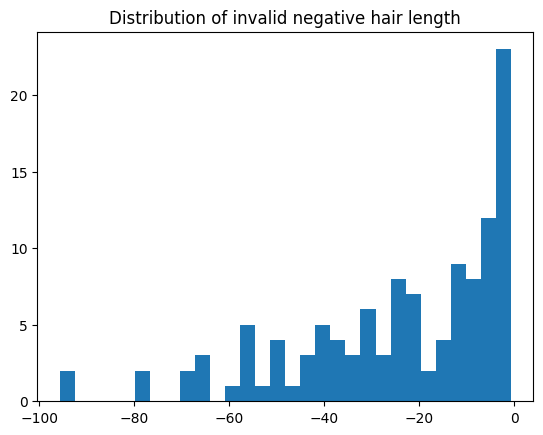

In [24]:
plt.hist(neg_hair.Hair_Length, bins=30)
plt.title("Distribution of invalid negative hair length");

This distribution of negative values roughly matches the distribution of positive ones.  There are a larger number of people with short hair of varying short lengths, and a tail of fewer people at longer lengths.  However, at a glance, the region close to zero seems to be a bit *too much* of a peak.  For the one hundred or so rows of data in the example, you could eyeball them all manually, but for larger data sets, or larger bounds-violation sets, honing in on nuances programmatically is more general.

In [25]:
neg_hair.Hair_Length.value_counts()

Hair_Length
-1.0     19
-8.5      2
-30.1     2
-6.8      2
-10.9     2
         ..
-30.5     1
-67.5     1
-40.6     1
-7.0      1
-39.3     1
Name: count, Length: 93, dtype: int64

Indeed there is a pattern here.  There are 19 values of *exactly* -1, and only 1 or two occurrences of each other invalid negative value.  It seems very likely that something different is happening between the -1 error and the other negative value errors.  Perhaps -1 was used as a sentinel, for example.  Of course, it is also possible that -1 could result from the stipulated sign-inversion error; we cannot entirely separate those two possibilities.

In [26]:
humans3 = humans2.copy()     # Versioned changes to data

# The "sentinel" negative value means missing
humans3.loc[humans3.Hair_Length == -1, 'Hair_Length'] = None

# All other values simply become non-negative
humans3['Hair_Length'] = humans3.Hair_Length.abs()

The working hypothesis I would probably use to handle this problem in the data set (if not simply drop everything questionable outright) would be to mark the -1 values as *missing* but invert the sign of other negative values.

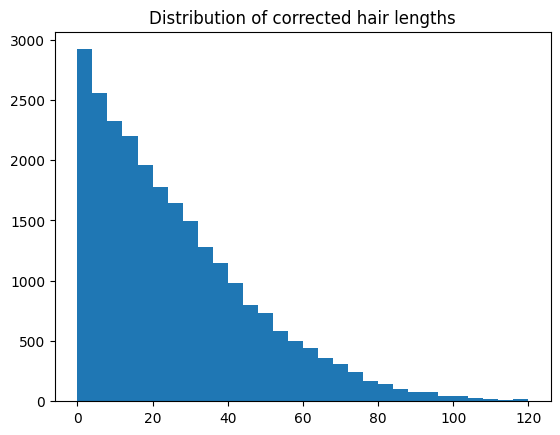

In [27]:
plt.hist(humans3.Hair_Length, bins=30)
plt.title("Distribution of corrected hair lengths");

We have performed a typical cleaning of bounded values.  Let us turn to values without sharp bounds, but with general distribution statistics.

## Outliers 

* Z-score and unexpected values
* Interquartile range
* Standard deviation and frequency of occurrence

In continuous data, values that fall within normative ranges might still be strongly uncharacteristic within those bounded expectations.  In the simplest case, this occurs when a value is very different from other values of the same variable.

### Z-score formula 

$$Z = \frac{x - \mu}{\sigma}$$

Where $\mu$ is sample mean, and $\sigma$ is standard deviation.

A standard way to characterize the expectedness of a value is a measure called z-score.  This value is simply the distance of each point from the mean of the variable, divided by the standard deviation of the variable. 

This measure is most precise for data that follows a normal distribution, but generally it is useful for any data that is unimodal, somewhat symmetric, and scale dependent.  In more ordinary language, we just want to look for the histogram of a data variable having one peak, and tapering off at roughly the same rate on both sides.  A completely normal distribution is unusual in real-world data.

A slightly different way of identifying outliers is often used as well.  Box and whisker plots (usually simply called boxplots) will often include outliers as separate visual elements.  While it is possible to use z-score in such a visualization, more often these plots utilize interquartile range (IQR) and a fixed multiplier to define outliers.  The different techniques will produce similar, but not identical, answers.

Text(0.5, 1.0, 'Distribution of Weight')

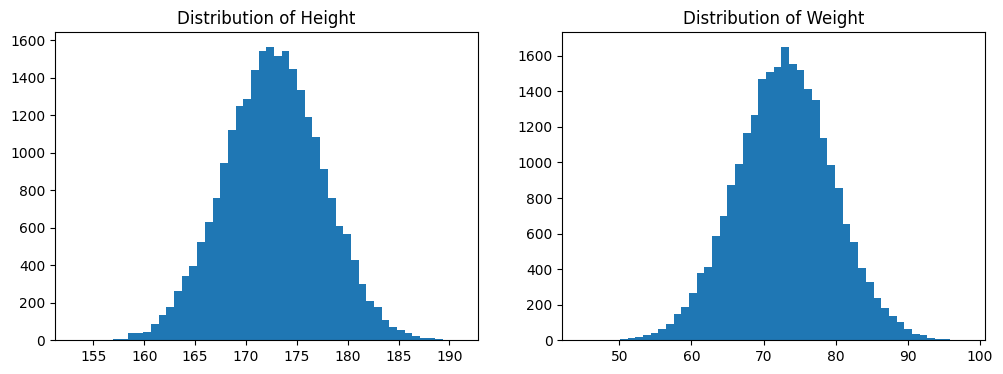

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(humans3.Height, bins=50)
ax2.hist(humans3.Weight, bins=50)
ax1.set_title("Distribution of Height")
ax2.set_title("Distribution of Weight")

We can see that height and weight in our data set follow a generally normal-like distribution by visualizing them.  We have seen earlier that hair length, after correction, is strictly single tailed.  However, the one-sided drop-off from a mode at 0 is close enough to one tail of a normal distribution, that z-score is still reasonable to consider.

If we wish to be more precise in quantifying normality of variables, we can use statistical tests such and Anderson-Darling, Shapiro–Wilk, or Skewness-Kurtosis All.  Each of these techniques tries to reject the hypothesis that a distribution is normal.  For different p-values (probabilities), different test statistics determine a threshold for this rejection (although for large samples, even small deviations from normality will reject the hypothesis, but not matter from the point of view of z-score being useful).  

In Anderson-Darling, if the test statistic is not much more than 1.0 the curve is definitely *normal enough* to measure outliers with z-score.  The inverse does not hold, however; many non-normal curves are still reasonable to use z-score with.  Essentially, we just need to avoid this measure for power law or exponential distributions, and for curves that are strongly multi-modal. 

Let us perform Anderson-Darling tests on our height, weight, and hair length variables.Let us perform Anderson-Darling tests on our height, weight, and hair length variables.

In [29]:
from scipy.stats import anderson

for var in ('Height', 'Weight', 'Hair_Length'):
    data = humans3[var][humans3[var].notnull()]
    stat = anderson(data, 'norm').statistic
    print(f"Anderson-Darling statistic for {var:<12s}: {stat:6.2f}")

Anderson-Darling statistic for Height      :   0.24
Anderson-Darling statistic for Weight      :   0.54
Anderson-Darling statistic for Hair_Length : 578.19


Having recognized that hair length is not normal, but that it shows a one-sided decay along a linear scale nonetheless, we can add z-scores for all of our quantitative variables to the working data frame.  As before, as good practice of keeping versions of our modifications, we copy the data to a new data frame before the next transformations.  

We ignore the delta degrees of freedom parameter in our calculation of standard deviation because it is trivial with 25 thousand samples (if we had only 10 or 20 samples, it could matter).  The degrees of freedom concerns the anticipated variance within a total population based on a sample; but these only vary significantly when samples are tens of observations, not tens of thousands. 

In [30]:
humans4 = humans3.copy()

for var in ('Height', 'Weight', 'Hair_Length'):
    zscore = (humans4[var] - humans4[var].mean()) / humans4[var].std()
    humans4[f"zscore_{var}"] = zscore
    
humans4.sample(5, random_state=1)

,Height,Weight,Hair_Length,Favorite,zscore_Height,zscore_Weight,zscore_Hair_Length
21492,176.958650,72.604585,14.0,red,0.880831,-0.042032,-0.568786
9488,169.000221,79.559843,0.0,blue,-0.766210,0.997585,-1.225152
16933,171.104306,71.125528,5.5,red,-0.330758,-0.263109,-0.967294
12604,174.481084,79.496237,8.1,blue,0.368085,0.988078,-0.845397
8222,171.275578,77.094118,14.6,green,-0.295312,0.629028,-0.540656


The choice of a z-score threshold is very domain and problem dependent.  A rule of thumb is often to use a z-score of absolute value more than 3 as a cut-off to define outliers.  But what is *expected* very much depends on the size of a data set.  

In statistics, we sometimes recall the "68–95–99.7 Rule" which lists the percentage of observations that fall within one, two, or three standard deviations in a normal distribution.  At any distance from the mean, *some* observations would be expected if they are numerous enough, but the number diminishes rapidly with more standard deviations distance.

Let's look at that common z-score threshold of 3.  Remember that we are working with 25,000 samples here, so generally we expect to find roughly 75 of them outside of 3 standard deviations. Let's look at the table for height, but just check the number of rows outside this bound for the other variables.

In [31]:
print("Unusual heights:", 
      len(humans4[humans4.zscore_Height.abs() > 3]))
humans4[humans4.zscore_Height.abs() > 3].sample(10)

Unusual heights: 51


,Height,Weight,Hair_Length,Favorite,zscore_Height,zscore_Weight,zscore_Hair_Length
9492,188.109733,76.750106,32.7,red,3.188608,0.577608,0.307932
412,157.522316,62.564977,6.8,blue,-3.141625,-1.542673,-0.906345
24244,158.153049,59.725932,13.8,green,-3.011091,-1.967031,-0.578162
10635,187.669780,77.991486,37.7,green,3.097558,0.763159,0.542348
15209,189.483822,84.332363,2.8,red,3.472984,1.710944,-1.093878
22471,189.275314,84.303399,23.1,green,3.429832,1.706614,-0.142148
13971,153.107034,63.155154,4.4,green,-4.055392,-1.454458,-1.018865
24801,189.310696,85.406727,2.3,green,3.437154,1.871531,-1.117320
14106,157.244415,45.062151,70.7,red,-3.199138,-4.158856,2.089496
11173,188.386644,81.886770,2.0,green,3.245917,1.345396,-1.131385


In [32]:
print("Outlier weight:", (humans4.zscore_Weight.abs() > 3).sum())
print("Outlier hair length:", (humans4.zscore_Hair_Length.abs() > 3).sum())

Outlier weight: 67
Outlier hair length: 285


We have already noted that hair length is single tailed, so we might expect approximately twice as many outliers.  The actual number is somewhat more than twice that many, but that is not itself an extreme divergence of values.  Height and weight actually have modestly lower kurtosis than we would expect from the normal distribution (the tails thin out slightly faster).  In any case, a z-score of 3 is probably too small to be useful for our sample size.  4 sigma is probably more relevant for our purpose of distinguishing merely-unusual from probably-wrong observations, and maybe 4.5 for the one-tailed hair length.

### Frequency of once-a-day observations falling outside of a given standard deviation

| Range | Proportion of observations | Frequency for daily event 
|-------|----------------------------|:---------------------------------
| ± 1σ  | 1 in 3                     | Twice a week
| ± 2σ  | 1 in 22                    | Every three weeks 
| ± 3σ  | 1 in 370                   | Yearly
| ± 4σ  | 1 in  15,787               | 43 years (twice in a lifetime)
| ± 5σ  | 1 in  1,744,278            | 5000 years (once in recorded history)
| ± 6σ  | 1 in  506,797,346          | 1.4 million years (twice in history of humankind)
| ± 7σ  | 1 in  390,682,215,445      | 1 billion years (four times in history of Earth) 

Let us see the outliers given the broader z-score bounds.

In [33]:
cond = (
    (humans4.zscore_Height.abs() > 4) |
    (humans4.zscore_Weight.abs() > 4) |
    (humans4.zscore_Hair_Length.abs() > 4.5))
humans4[cond] 

,Height,Weight,Hair_Length,Favorite,zscore_Height,zscore_Weight,zscore_Hair_Length
13971,153.107034,63.155154,4.4,green,-4.055392,-1.454458,-1.018865
14106,157.244415,45.062151,70.7,red,-3.199138,-4.158856,2.089496
22945,157.293031,44.744929,18.4,red,-3.189077,-4.206272,-0.362499


Using modest domain knowledge of human physical characteristics, even though they are outside the "norm," persons of  153㎝ or 45kg are small, but not outside of bounds we might encounter.  The small number of 4 sigma outliers are both short and light according to the data, which we would expect to be correlated to a relatively high degree, lending plausibility to the measurements.

The height bounds we discussed in the above section on fixed bounds were considerably wider than this 4 sigma (or even 5 sigma) detects.  Therefore, while we *could* discard or mark missing values in these outliers rows, the analysis does not seem to motivate doing so.

### Interquartile Range

Using interquartile range (IQR) rather than z-score makes less of an assumption of normality of a distribution.  However, this technique will also fails to produce meaningful answers for power law or exponential data distributions.

If you can identify a distribution as one that ranges over many orders of magnitude like those, looking at the quartiles of either an Nth root or a logarithm of the raw data might still produce reasonable results.  The same transformation, in fact, can be equally relevant if you use z-score analysis.

The idea of IQR is simply to look at the quartile cut-offs in a variable, and measure the numeric distance between the first and third quartile, i.e. between the 25% and 75% percentiles.  Exactly half the data is in that range, but we often also expect that most data will be within some distance beyond those cut-offs, defined as a multiplier of the range between cut-offs.  Most commonly, a multiplier of 1.5 is chosen; this is merely a convention that is often useful but lacks any deeper meaning.

In [34]:
# Function defined but not run in this cell
def show_boxplots(df, cols, whis=1.5):
    # Create as many horizontal plots as we have columns
    fig, axes = plt.subplots(len(cols), 1, figsize=(10, 1.5*len(cols)))
    # For each one, plot the non-null data inside it
    for n, col in enumerate(cols):
        data = df[col][df[col].notnull()]
        axes[n].set_title(f'{col} Distribution')
        # Extend whiskers to specified IQR multiplier
        axes[n].boxplot(data, whis=whis, vert=False, sym='x')
        axes[n].set_yticks([])
    # Fix spacing of subplots at the end
    fig.tight_layout()

The function shown will visualize boxplots that show the IQR defined outliers.

While the default multiplier (the "whisker" width) is 1.5, we have already seen that the human data is large enough that values have to be relatively extreme to appear as genuinely *unlikely* to be genuine.  We choose, therefore, a whisker width of 2.5 instead.  

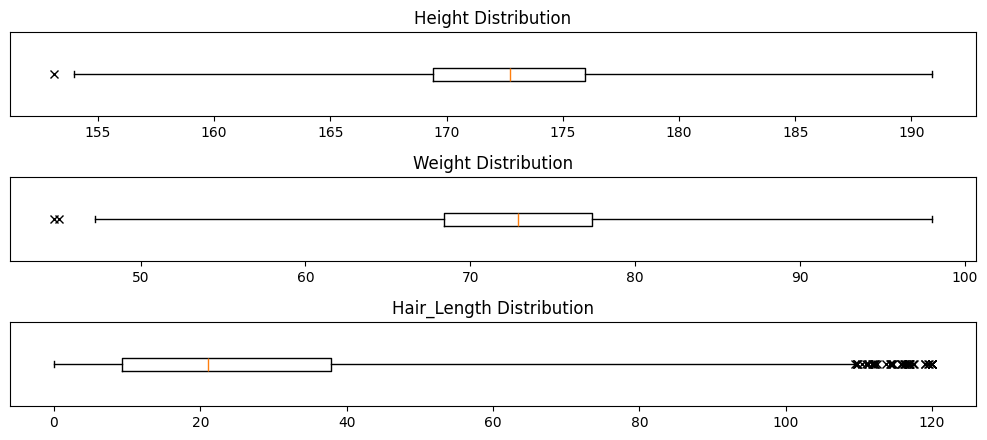

In [35]:
show_boxplots(humans4, ["Height", "Weight", "Hair_Length"], 2.5)

The central boxes represent the IQR, from 25% to 75% percentile.  The whiskers extend to multiplier times IQR above/below the box.  An x marks outliers past the whiskers.

Only one outlier appears at this threshold for height, at the short end.  Likewise, only two appear for weight, both at the light end.  This was the same pattern we found with z-score.

Rather more "outlier" long hair lengths occurs, but we already had used a larger z-score to filter that more restrictively.  We could similarly use a larger *whisker* width to filter more hair lengths out, if we wished.

In [36]:
quartiles = (
    humans4[['Height', 'Weight']]
    .quantile(q=[0.25, 0.50, 0.75, 1.0]))
quartiles

,Height,Weight
0.25,169.428884,68.428823
0.50,172.709078,72.930616
0.75,175.953541,77.367039
1.00,190.888112,98.032504


While the visualization is handy. We can also examine the specific values (in centimeters and kilograms) that define the quartiles.

Univariate outliers can be important to detect, but sometimes it is a combination of features that becomes anomalous.

## Multivariate Outliers 

* Variance in deterministic synthetic features
* Expectations of relative rarity

Sometimes univariate features can fall within relatively moderate z-score boundaries, and yet combinations of those features are unlikely or unreasonable.  Perhaps an actual machine learning model might predict that combinations of features are likely to be wrong.  In this section we only look at simpler combinations of features to identify problematic samples.

In a later lesson we discuss polynomial features.  That technique multiplies together the values of two or more variables pertaining to the same observation, and treats that as a new feature.  For example, perhaps neither height nor weight in our working example are outside a reasonable bound, and yet the multiplicative product of them is.  While this is definitely possible, we generally expect these features to be positively correlated to start with, so multiplication would probably only produce something *slightly* outside the bounds already detected by univariate outlier detection.

### BMI formula

$$BMI = \frac{kg}{m^2}$$

Let us consider a derived feature that is well-motivated by the specific domain of human measurements we've been using.  Body mass index (BMI) is a measure often used to measure healthy weights for people.

That is, weight and height are in an inverse relationship in this derived quantity rather than multiplicatively combined.  Perhaps this multivariate derived features shows some problem outliers.  Let us construct another data frame version that discards previous calculated columns, but adds BMI and its z-score.

In [37]:
humans5 = humans4[['Height', 'Weight']].copy()
# Convert weight from cm to m
humans5['BMI'] = humans5.Weight / (humans5.Height/100)**2
humans5["zscore_BMI"] = (
    (humans5.BMI - humans5.BMI.mean()) / 
     humans5.BMI.std()
)
humans5

,Height,Weight,BMI,zscore_BMI
0,167.089607,64.806216,23.212279,-0.620410
1,181.648633,78.281527,23.724388,-0.359761
2,176.272800,87.767722,28.246473,1.941852
3,173.270164,81.635672,27.191452,1.404877
4,172.181037,82.760794,27.916053,1.773678
...,...,...,...,...
24995,176.535461,67.696134,21.722007,-1.378916
24996,163.952580,68.936137,25.645456,0.618008
24997,164.334317,67.830516,25.117048,0.349063
24998,171.524117,75.861686,25.785295,0.689182


Looking for outliers in the derived feature, we see strong signals.  As was discussed, at a z-score of 4 and a data set of 25,000 records, we expect to see slightly more than one record appearing as an outlier by natural random distribution. 

In [38]:
humans5[humans5.zscore_BMI.abs() > 4]

,Height,Weight,BMI,zscore_BMI
21388,165.912597,90.579409,32.905672,4.313253
23456,187.110000,52.920000,15.115616,-4.741383
23457,158.330000,92.780000,37.010755,6.402625
24610,169.082822,47.250297,16.527439,-4.022805


As well as one example of a moderate outlier for high BMI and one for low BMI, we also have two more extreme values on each side.  

The -4.74 z-score is not an extreme we would expect in 25,000 samples, but is perhaps not completely implausible.  However, the +6.4 z-score is astronomically unlikely to occur without a data error.  

Since BMI is a derived feature that combines height and weight—and moreover since each of those is within reasonable bounds on its own—the correct approach is almost surely simply to discard this problem row.  Nothing in the data themselves guide us towards knowing whether weight or height is the problem value, and no remediation is sensible.

Fortunately for this particular data set, only 2 (or *maybe* 4) samples display the problem under discussion.  We have plentiful data here, and often no real harm is done by discarding those rows.  

The particular decisions made about z-score thresholds and disposition of particular data rows that are illustrated in this section and the last several are only examples.  You will need to decide within your problem and domain what are most relevant levels and tests, and what remediations to perform.

## Denouement

_When you have eliminated the impossible, whatever remains, 
however improbable, must be the truth._

–Arthur Conan Doyle

The anomalies that we have discussed in this chapter fall into a few relatively distinct categories.  For the first kind, there are the special values that explicitly mark missing data, although those markers are sometimes subject to pitfalls.  However, an explicit indication of missingness is probably the most straightforward kind of anomaly.  

A second kind of anomaly are categorical values that a miscoded; some finite number of values are proper (although not always clearly documented), and anything that isn't one of those few values is an anomaly.

The third kind of anomaly is in continuous—or at least ranged—data values that fall outside of the bounds of our expectations.  These are also called *outliers*, although exactly how much a value has to lie outside typical values to be a problem is very domain and problem dependent.

Expectations may take the form of *a priori* that arise from domain knowledge of the measurement. They may also arise from the distribution of data within a variable overall, and the deviation of one particular value from others measurements of that variable.  

At times, our expectations about bounds can even be multivariate, and some numeric combination of multiple variables produces a value outside of expectation bounds.

For all of these kinds of anomalies, there are essentially two actions we might take.  We may decide to discard an observation altogether if it has one of these problems.  Alternately, we may simply more explicitly mark one feature within an observation as explicitly missing based on its value not being reliable.  

When we modify values to the "missing" special value, keeping track of our changes and data versions is extremely important practice.  What we choose to do with those values marked as explicitly missing is a downstream decision that is discussed in later lessons.